<a href="https://colab.research.google.com/github/t-tsue/public/blob/main/PBL02_sample_vith14_bin2_ep80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
DIR='/content/drive/My Drive/DXQuest_PBL02/'

Mounted at /content/drive


In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd

train_files = glob.glob(os.path.join(DIR,'train', '*/*.jpeg'))
test_files = sorted(glob.glob(os.path.join(DIR,'test', '*.jpeg')))

train_df = pd.DataFrame(train_files, columns=['file_name'])
test_df = pd.DataFrame(test_files, columns=['file_name'])

In [3]:
def get_label(x):
  # (regular → horn)
  # regular_008.jpeg
  #if 'regular_008' in x:
  #  return 1

  # (horn → regular)
  # horn_016.jpeg
  #if 'horn_016' in x:
  #  return 0

  #(potato → regular)
  # potato_037.jpeg
  #if 'potato_037' in x:
  #  return 0

  if 'bridge' in x:
    return 1
  elif 'horn' in x:
    return 1
  elif 'potato' in x:
    return 1
  else:
    return 0

train_df['label'] = train_df['file_name'].apply(get_label)

In [4]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.optim as optim
import random
import torch.utils.data as data
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.model_selection import StratifiedKFold

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#torch.set_default_device(device)

In [6]:
SIZE = 518
CSIZE = 518
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

class ImageTransform():
  def __init__(self, phase, resize = SIZE, csize=CSIZE, mean = MEAN, std = STD):
    self.phase = phase
    if phase == 'train':
      self.data_transform = transforms.Compose([
          transforms.RandomResizedCrop(resize,scale=(0.9,1)),
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          transforms.RandomRotation(degrees=(-10,10)),
          transforms.ToTensor(),
          transforms.Normalize(mean, std)
      ])
    else:
      self.data_transform = transforms.Compose([
          transforms.Resize(resize),
          transforms.CenterCrop(csize),
          transforms.ToTensor(),
          transforms.Normalize(mean, std)
      ])

  def __call__(self, img):
    return self.data_transform(img)

In [7]:
class CustomDataset(Dataset):
  def __init__(self, df, phase='train'):
    self.df = df
    self.transform = ImageTransform(phase)
    self.phase = phase

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    if self.phase != 'test':
      img_path = self.df.iloc[index]['file_name']
      img = Image.open(img_path)
      img_transformed = self.transform(img)
      label = self.df.iloc[index]['label']
      return img_transformed, label
    else:
      img_path = self.df.iloc[index]['file_name']
      img = Image.open(img_path)
      img_transformed = self.transform(img)
      return img_transformed


In [8]:
def train_model(net, dataloader_dict, criterion, optimizer, num_epochs):
  best_loss = 99
  best_acc = 0
  scores=[]
  net.to(device)
  # epochのループ
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-------------')
    for phase in ['train', 'val']:
      if phase == 'train':
        net.train()  # モデルを訓練モードに
      else:
        net.eval()   # モデルを検証モードに

      # epochごとの学習と検証のループ

      epoch_loss = 0.0  # epochの損失和
      epoch_corrects = 0  # epochの正解数


      # データローダーからミニバッチを取り出すループ
      dataloader = dataloader_dict[phase]
      for inputs, labels in tqdm(dataloader):

        # optimizerを初期化
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 順伝搬（forward）計算
        with torch.set_grad_enabled(phase=='train'):
          outputs = net(inputs)
          loss = criterion(outputs, labels)  # 損失を計算
          _, preds = torch.max(outputs, 1)  # ラベルを予測


          # 訓練時はバックプロパゲーション
          if phase == 'train':
            loss.backward()
            optimizer.step()

          # イタレーション結果の計算
          # lossの合計を更新
          epoch_loss += loss.item() * inputs.size(0)
          # 正解数の合計を更新
          epoch_corrects += torch.sum(preds == labels.data)

      # epochごとのlossと正解率を表示
      epoch_loss = epoch_loss / len(dataloader.dataset)
      epoch_acc = epoch_corrects.double(
      ) / len(dataloader.dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
          phase, epoch_loss, epoch_acc))
      if phase == 'val':
        if epoch_loss < best_loss:
          best_loss = epoch_loss
          torch.save(net.to('cpu').state_dict(), os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOCHS}_best_loss_bin2.pth'))
          net.to(device)
        if epoch_acc > best_acc:
          best_acc = epoch_acc
          torch.save(net.to('cpu').state_dict(), os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOCHS}_best_acc_bin2.pth'))
          net.to(device)
      scores.append([epoch, phase, epoch_loss, epoch_acc])
  return net, pd.DataFrame(scores, columns=['epoch', 'phase', 'loss', 'acc'])

In [9]:
BATCH_SIZE = 60
EPOCHS = 80
LEARNING_RATE = 0.001
#MOMENTUM = 0.9

def get_model():
  weights = models.ViT_H_14_Weights.IMAGENET1K_SWAG_E2E_V1  # 学習済みのパラメータを使用
  net = models.vit_h_14(weights=weights)
  net.heads.head = nn.Linear(in_features=1280, out_features=2, bias=True)
  return net

def get_criterion():
  criterion = nn.CrossEntropyLoss()
  return criterion

def get_optimizer(net):
  params_to_update = []

  update_param_names = ["encoder.ln.weight", "encoder.ln.bias", "heads.head.weight", "heads.head.bias"]

  for name, param in net.named_parameters():
    if name in update_param_names:
      param.requires_grad = True
      params_to_update.append(param)
    else:
      param.requires_grad = False

  optimizer = optim.Adam(params_to_update, lr=LEARNING_RATE, )
  return optimizer

In [10]:
def predict(net, dataloader):
  net = net.to(device)
  net.eval()
  result=[]
  for inputs in dataloader:
    outputs = net(inputs.to(device))
    outputs = list(outputs.detach().cpu().numpy())
    result.extend(outputs)
  return np.argmax(np.array(result),axis=1)

def predict_proba(net, dataloader):
  net = net.to(device)
  net.eval()
  result=[]
  for inputs in dataloader:
    outputs = net(inputs.to(device))
    outputs = list(outputs.detach().cpu().numpy())
    result.extend(outputs)
  result = np.array(result)
  pred_0 = result[:,0]
  pred_1 = result[:,1]
  return np.exp(pred_1)/(np.exp(pred_0)+np.exp(pred_1))

def get_score(y_true, y_pred):
  y_true = (y_true > 0).astype(int)
  y_pred = (y_pred > 0).astype(int)
  acc = accuracy_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  return [acc, recall, precision, f1]

SEED=42

def init_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

for seed in range(1):
  seed = SEED + seed
  init_seed(seed)
  g = torch.Generator()
  g.manual_seed(seed)
  skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=seed)
  X = train_df
  y = train_df['label']
  MODEL_DIR=os.path.join(DIR,'model')
  os.makedirs(MODEL_DIR, exist_ok=True)
  for iter, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    train_dataset = CustomDataset(X_train, phase='train')
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                                    worker_init_fn=seed_worker,generator=g)
    val_dataset = CustomDataset(X_val, phase='val')
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    net = get_model()
    criterion = get_criterion()
    optimizer = get_optimizer(net)
    dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}
    net,score = train_model(net, dataloader_dict, criterion, optimizer, EPOCHS)
    torch.save(net.to('cpu').state_dict(), os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOCHS}_{iter}_bin2.pth'))
    break

Downloading: "https://download.pytorch.org/models/vit_h_14_swag-80465313.pth" to /root/.cache/torch/hub/checkpoints/vit_h_14_swag-80465313.pth
100%|██████████| 2.36G/2.36G [00:28<00:00, 87.9MB/s]


Epoch 1/80
-------------


100%|██████████| 5/5 [06:40<00:00, 80.19s/it]


train Loss: 0.8624 Acc: 0.5613


100%|██████████| 1/1 [00:52<00:00, 52.75s/it]


val Loss: 0.6432 Acc: 0.6486
Epoch 2/80
-------------


100%|██████████| 5/5 [04:21<00:00, 52.35s/it]


train Loss: 0.7571 Acc: 0.4704


100%|██████████| 1/1 [00:31<00:00, 31.40s/it]


val Loss: 0.6244 Acc: 0.5946
Epoch 3/80
-------------


100%|██████████| 5/5 [04:12<00:00, 50.53s/it]


train Loss: 0.6286 Acc: 0.6877


100%|██████████| 1/1 [00:30<00:00, 30.61s/it]


val Loss: 0.7794 Acc: 0.6486
Epoch 4/80
-------------


100%|██████████| 5/5 [04:08<00:00, 49.72s/it]


train Loss: 0.6024 Acc: 0.6877


100%|██████████| 1/1 [00:31<00:00, 31.07s/it]


val Loss: 0.6355 Acc: 0.6486
Epoch 5/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.45s/it]


train Loss: 0.6342 Acc: 0.6680


100%|██████████| 1/1 [00:31<00:00, 31.25s/it]


val Loss: 0.6294 Acc: 0.7027
Epoch 6/80
-------------


100%|██████████| 5/5 [04:08<00:00, 49.65s/it]


train Loss: 0.6266 Acc: 0.6798


100%|██████████| 1/1 [00:30<00:00, 30.65s/it]


val Loss: 0.6532 Acc: 0.6757
Epoch 7/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.50s/it]


train Loss: 0.5376 Acc: 0.7154


100%|██████████| 1/1 [00:31<00:00, 31.03s/it]


val Loss: 0.5938 Acc: 0.6486
Epoch 8/80
-------------


100%|██████████| 5/5 [04:13<00:00, 50.64s/it]


train Loss: 0.5336 Acc: 0.7312


100%|██████████| 1/1 [00:29<00:00, 29.88s/it]


val Loss: 0.5810 Acc: 0.7297
Epoch 9/80
-------------


100%|██████████| 5/5 [04:21<00:00, 52.37s/it]


train Loss: 0.4989 Acc: 0.7510


100%|██████████| 1/1 [00:29<00:00, 29.80s/it]


val Loss: 0.5294 Acc: 0.7838
Epoch 10/80
-------------


100%|██████████| 5/5 [04:16<00:00, 51.27s/it]


train Loss: 0.4955 Acc: 0.8063


100%|██████████| 1/1 [00:29<00:00, 29.92s/it]


val Loss: 0.5327 Acc: 0.7838
Epoch 11/80
-------------


100%|██████████| 5/5 [04:09<00:00, 49.85s/it]


train Loss: 0.4867 Acc: 0.7549


100%|██████████| 1/1 [00:31<00:00, 31.00s/it]


val Loss: 0.5274 Acc: 0.7838
Epoch 12/80
-------------


100%|██████████| 5/5 [04:06<00:00, 49.38s/it]


train Loss: 0.4747 Acc: 0.7747


100%|██████████| 1/1 [00:30<00:00, 30.97s/it]


val Loss: 0.4923 Acc: 0.7838
Epoch 13/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.44s/it]


train Loss: 0.4537 Acc: 0.7905


100%|██████████| 1/1 [00:30<00:00, 30.75s/it]


val Loss: 0.4956 Acc: 0.8108
Epoch 14/80
-------------


100%|██████████| 5/5 [04:10<00:00, 50.07s/it]


train Loss: 0.4422 Acc: 0.7708


100%|██████████| 1/1 [00:31<00:00, 31.23s/it]


val Loss: 0.4841 Acc: 0.8108
Epoch 15/80
-------------


100%|██████████| 5/5 [04:10<00:00, 50.11s/it]


train Loss: 0.4342 Acc: 0.7589


100%|██████████| 1/1 [00:30<00:00, 30.01s/it]


val Loss: 0.4723 Acc: 0.8108
Epoch 16/80
-------------


100%|██████████| 5/5 [04:09<00:00, 49.87s/it]


train Loss: 0.4221 Acc: 0.7945


100%|██████████| 1/1 [00:31<00:00, 31.27s/it]


val Loss: 0.4671 Acc: 0.8108
Epoch 17/80
-------------


100%|██████████| 5/5 [04:08<00:00, 49.69s/it]


train Loss: 0.4192 Acc: 0.7984


100%|██████████| 1/1 [00:31<00:00, 31.07s/it]


val Loss: 0.4763 Acc: 0.8108
Epoch 18/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.50s/it]


train Loss: 0.4364 Acc: 0.7866


100%|██████████| 1/1 [00:31<00:00, 31.31s/it]


val Loss: 0.4588 Acc: 0.8108
Epoch 19/80
-------------


100%|██████████| 5/5 [04:10<00:00, 50.10s/it]


train Loss: 0.4032 Acc: 0.8261


100%|██████████| 1/1 [00:29<00:00, 29.78s/it]


val Loss: 0.4528 Acc: 0.8108
Epoch 20/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.41s/it]


train Loss: 0.3963 Acc: 0.8458


100%|██████████| 1/1 [00:31<00:00, 31.23s/it]


val Loss: 0.4472 Acc: 0.8108
Epoch 21/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.47s/it]


train Loss: 0.4134 Acc: 0.7984


100%|██████████| 1/1 [00:31<00:00, 31.28s/it]


val Loss: 0.4282 Acc: 0.7838
Epoch 22/80
-------------


100%|██████████| 5/5 [04:09<00:00, 49.90s/it]


train Loss: 0.4038 Acc: 0.8340


100%|██████████| 1/1 [00:31<00:00, 31.02s/it]


val Loss: 0.4210 Acc: 0.8108
Epoch 23/80
-------------


100%|██████████| 5/5 [04:14<00:00, 50.84s/it]


train Loss: 0.3776 Acc: 0.8024


100%|██████████| 1/1 [00:29<00:00, 29.89s/it]


val Loss: 0.4426 Acc: 0.8108
Epoch 24/80
-------------


100%|██████████| 5/5 [04:11<00:00, 50.20s/it]


train Loss: 0.3867 Acc: 0.8340


100%|██████████| 1/1 [00:29<00:00, 29.82s/it]


val Loss: 0.4083 Acc: 0.8108
Epoch 25/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.50s/it]


train Loss: 0.3891 Acc: 0.8103


100%|██████████| 1/1 [00:31<00:00, 31.37s/it]


val Loss: 0.4059 Acc: 0.8108
Epoch 26/80
-------------


100%|██████████| 5/5 [04:08<00:00, 49.78s/it]


train Loss: 0.3654 Acc: 0.8577


100%|██████████| 1/1 [00:31<00:00, 31.36s/it]


val Loss: 0.4203 Acc: 0.8108
Epoch 27/80
-------------


100%|██████████| 5/5 [04:06<00:00, 49.27s/it]


train Loss: 0.3782 Acc: 0.8103


100%|██████████| 1/1 [00:31<00:00, 31.39s/it]


val Loss: 0.4081 Acc: 0.8108
Epoch 28/80
-------------


100%|██████████| 5/5 [04:06<00:00, 49.40s/it]


train Loss: 0.3575 Acc: 0.8775


100%|██████████| 1/1 [00:30<00:00, 30.97s/it]


val Loss: 0.3990 Acc: 0.8108
Epoch 29/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.43s/it]


train Loss: 0.3447 Acc: 0.8498


100%|██████████| 1/1 [00:31<00:00, 31.01s/it]


val Loss: 0.3997 Acc: 0.8108
Epoch 30/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.41s/it]


train Loss: 0.3488 Acc: 0.8735


100%|██████████| 1/1 [00:31<00:00, 31.20s/it]


val Loss: 0.3950 Acc: 0.8108
Epoch 31/80
-------------


100%|██████████| 5/5 [04:09<00:00, 49.82s/it]


train Loss: 0.3378 Acc: 0.8735


100%|██████████| 1/1 [00:31<00:00, 31.14s/it]


val Loss: 0.3926 Acc: 0.8108
Epoch 32/80
-------------


100%|██████████| 5/5 [04:11<00:00, 50.38s/it]


train Loss: 0.3345 Acc: 0.8656


100%|██████████| 1/1 [00:29<00:00, 29.79s/it]


val Loss: 0.3827 Acc: 0.8108
Epoch 33/80
-------------


100%|██████████| 5/5 [04:10<00:00, 50.15s/it]


train Loss: 0.3410 Acc: 0.8696


100%|██████████| 1/1 [00:30<00:00, 30.02s/it]


val Loss: 0.3763 Acc: 0.8108
Epoch 34/80
-------------


100%|██████████| 5/5 [04:10<00:00, 50.06s/it]


train Loss: 0.3276 Acc: 0.8854


100%|██████████| 1/1 [00:31<00:00, 31.10s/it]


val Loss: 0.3802 Acc: 0.8108
Epoch 35/80
-------------


100%|██████████| 5/5 [04:06<00:00, 49.36s/it]


train Loss: 0.3235 Acc: 0.9170


100%|██████████| 1/1 [00:31<00:00, 31.24s/it]


val Loss: 0.3980 Acc: 0.8378
Epoch 36/80
-------------


100%|██████████| 5/5 [04:12<00:00, 50.54s/it]


train Loss: 0.3883 Acc: 0.7866


100%|██████████| 1/1 [00:29<00:00, 29.85s/it]


val Loss: 0.3897 Acc: 0.8378
Epoch 37/80
-------------


100%|██████████| 5/5 [04:10<00:00, 50.18s/it]


train Loss: 0.3433 Acc: 0.8893


100%|██████████| 1/1 [00:29<00:00, 29.96s/it]


val Loss: 0.3673 Acc: 0.8108
Epoch 38/80
-------------


100%|██████████| 5/5 [04:08<00:00, 49.74s/it]


train Loss: 0.3151 Acc: 0.8617


100%|██████████| 1/1 [00:30<00:00, 30.95s/it]


val Loss: 0.4112 Acc: 0.8378
Epoch 39/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.40s/it]


train Loss: 0.3069 Acc: 0.8656


100%|██████████| 1/1 [00:30<00:00, 30.66s/it]


val Loss: 0.3477 Acc: 0.8378
Epoch 40/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.48s/it]


train Loss: 0.3171 Acc: 0.8972


100%|██████████| 1/1 [00:31<00:00, 31.36s/it]


val Loss: 0.3860 Acc: 0.8378
Epoch 41/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.45s/it]


train Loss: 0.3070 Acc: 0.8735


100%|██████████| 1/1 [00:31<00:00, 31.52s/it]


val Loss: 0.3600 Acc: 0.8108
Epoch 42/80
-------------


100%|██████████| 5/5 [04:06<00:00, 49.33s/it]


train Loss: 0.2977 Acc: 0.9012


100%|██████████| 1/1 [00:31<00:00, 31.48s/it]


val Loss: 0.3735 Acc: 0.8108
Epoch 43/80
-------------


100%|██████████| 5/5 [04:06<00:00, 49.32s/it]


train Loss: 0.2846 Acc: 0.9209


100%|██████████| 1/1 [00:31<00:00, 31.30s/it]


val Loss: 0.3715 Acc: 0.8108
Epoch 44/80
-------------


100%|██████████| 5/5 [04:06<00:00, 49.25s/it]


train Loss: 0.2975 Acc: 0.8893


100%|██████████| 1/1 [00:31<00:00, 31.13s/it]


val Loss: 0.3572 Acc: 0.8378
Epoch 45/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.59s/it]


train Loss: 0.2936 Acc: 0.8933


100%|██████████| 1/1 [00:30<00:00, 30.08s/it]


val Loss: 0.3824 Acc: 0.8378
Epoch 46/80
-------------


100%|██████████| 5/5 [04:10<00:00, 50.06s/it]


train Loss: 0.2854 Acc: 0.8696


100%|██████████| 1/1 [00:29<00:00, 29.87s/it]


val Loss: 0.3454 Acc: 0.8378
Epoch 47/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.47s/it]


train Loss: 0.2921 Acc: 0.9249


100%|██████████| 1/1 [00:31<00:00, 31.29s/it]


val Loss: 0.3579 Acc: 0.8378
Epoch 48/80
-------------


100%|██████████| 5/5 [04:06<00:00, 49.39s/it]


train Loss: 0.3040 Acc: 0.8775


100%|██████████| 1/1 [00:31<00:00, 31.28s/it]


val Loss: 0.3492 Acc: 0.8649
Epoch 49/80
-------------


100%|██████████| 5/5 [04:06<00:00, 49.35s/it]


train Loss: 0.2718 Acc: 0.9170


100%|██████████| 1/1 [00:31<00:00, 31.42s/it]


val Loss: 0.3335 Acc: 0.8378
Epoch 50/80
-------------


100%|██████████| 5/5 [04:09<00:00, 50.00s/it]


train Loss: 0.2891 Acc: 0.9012


100%|██████████| 1/1 [00:31<00:00, 31.29s/it]


val Loss: 0.3560 Acc: 0.8108
Epoch 51/80
-------------


100%|██████████| 5/5 [04:06<00:00, 49.35s/it]


train Loss: 0.2560 Acc: 0.9051


100%|██████████| 1/1 [00:31<00:00, 31.02s/it]


val Loss: 0.3337 Acc: 0.8378
Epoch 52/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.53s/it]


train Loss: 0.2690 Acc: 0.9328


100%|██████████| 1/1 [00:30<00:00, 30.55s/it]


val Loss: 0.3357 Acc: 0.8378
Epoch 53/80
-------------


100%|██████████| 5/5 [04:14<00:00, 50.92s/it]


train Loss: 0.2901 Acc: 0.8775


100%|██████████| 1/1 [00:29<00:00, 29.85s/it]


val Loss: 0.3358 Acc: 0.8378
Epoch 54/80
-------------


100%|██████████| 5/5 [04:09<00:00, 49.95s/it]


train Loss: 0.3072 Acc: 0.9091


100%|██████████| 1/1 [00:30<00:00, 30.35s/it]


val Loss: 0.3420 Acc: 0.8378
Epoch 55/80
-------------


100%|██████████| 5/5 [04:09<00:00, 49.89s/it]


train Loss: 0.2813 Acc: 0.8854


100%|██████████| 1/1 [00:30<00:00, 30.67s/it]


val Loss: 0.3571 Acc: 0.8108
Epoch 56/80
-------------


100%|██████████| 5/5 [04:08<00:00, 49.62s/it]


train Loss: 0.2922 Acc: 0.8893


100%|██████████| 1/1 [00:30<00:00, 30.89s/it]


val Loss: 0.3357 Acc: 0.8378
Epoch 57/80
-------------


100%|██████████| 5/5 [04:08<00:00, 49.61s/it]


train Loss: 0.2957 Acc: 0.8696


100%|██████████| 1/1 [00:30<00:00, 30.69s/it]


val Loss: 0.3786 Acc: 0.8378
Epoch 58/80
-------------


100%|██████████| 5/5 [04:09<00:00, 49.83s/it]


train Loss: 0.2901 Acc: 0.8893


100%|██████████| 1/1 [00:30<00:00, 30.81s/it]


val Loss: 0.3249 Acc: 0.8649
Epoch 59/80
-------------


100%|██████████| 5/5 [04:08<00:00, 49.76s/it]


train Loss: 0.2661 Acc: 0.8814


100%|██████████| 1/1 [00:30<00:00, 30.66s/it]


val Loss: 0.4010 Acc: 0.8378
Epoch 60/80
-------------


100%|██████████| 5/5 [04:08<00:00, 49.73s/it]


train Loss: 0.2563 Acc: 0.9091


100%|██████████| 1/1 [00:30<00:00, 30.40s/it]


val Loss: 0.3245 Acc: 0.8378
Epoch 61/80
-------------


100%|██████████| 5/5 [04:16<00:00, 51.32s/it]


train Loss: 0.2651 Acc: 0.9209


100%|██████████| 1/1 [00:29<00:00, 29.90s/it]


val Loss: 0.3544 Acc: 0.8378
Epoch 62/80
-------------


100%|██████████| 5/5 [04:09<00:00, 49.87s/it]


train Loss: 0.2360 Acc: 0.9209


100%|██████████| 1/1 [00:30<00:00, 30.39s/it]


val Loss: 0.3252 Acc: 0.8378
Epoch 63/80
-------------


100%|██████████| 5/5 [04:08<00:00, 49.61s/it]


train Loss: 0.2499 Acc: 0.9130


100%|██████████| 1/1 [00:31<00:00, 31.05s/it]


val Loss: 0.3338 Acc: 0.8378
Epoch 64/80
-------------


100%|██████████| 5/5 [04:06<00:00, 49.38s/it]


train Loss: 0.2627 Acc: 0.9130


100%|██████████| 1/1 [00:31<00:00, 31.29s/it]


val Loss: 0.3286 Acc: 0.8378
Epoch 65/80
-------------


100%|██████████| 5/5 [04:06<00:00, 49.37s/it]


train Loss: 0.2266 Acc: 0.9407


100%|██████████| 1/1 [00:31<00:00, 31.40s/it]


val Loss: 0.3431 Acc: 0.8378
Epoch 66/80
-------------


100%|██████████| 5/5 [04:06<00:00, 49.27s/it]


train Loss: 0.2518 Acc: 0.9289


100%|██████████| 1/1 [00:30<00:00, 30.96s/it]


val Loss: 0.3218 Acc: 0.8378
Epoch 67/80
-------------


100%|██████████| 5/5 [04:14<00:00, 50.90s/it]


train Loss: 0.2545 Acc: 0.9170


100%|██████████| 1/1 [00:29<00:00, 29.94s/it]


val Loss: 0.3136 Acc: 0.8378
Epoch 68/80
-------------


100%|██████████| 5/5 [04:09<00:00, 49.83s/it]


train Loss: 0.2364 Acc: 0.9447


100%|██████████| 1/1 [00:31<00:00, 31.26s/it]


val Loss: 0.3219 Acc: 0.8378
Epoch 69/80
-------------


100%|██████████| 5/5 [04:06<00:00, 49.26s/it]


train Loss: 0.2405 Acc: 0.9249


100%|██████████| 1/1 [00:31<00:00, 31.26s/it]


val Loss: 0.3067 Acc: 0.8378
Epoch 70/80
-------------


100%|██████████| 5/5 [04:06<00:00, 49.36s/it]


train Loss: 0.2307 Acc: 0.9328


100%|██████████| 1/1 [00:31<00:00, 31.21s/it]


val Loss: 0.3127 Acc: 0.8378
Epoch 71/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.41s/it]


train Loss: 0.2439 Acc: 0.9130


100%|██████████| 1/1 [00:31<00:00, 31.26s/it]


val Loss: 0.3102 Acc: 0.8378
Epoch 72/80
-------------


100%|██████████| 5/5 [04:06<00:00, 49.34s/it]


train Loss: 0.2423 Acc: 0.8775


100%|██████████| 1/1 [00:31<00:00, 31.14s/it]


val Loss: 0.3004 Acc: 0.8378
Epoch 73/80
-------------


100%|██████████| 5/5 [04:11<00:00, 50.37s/it]


train Loss: 0.2317 Acc: 0.9526


100%|██████████| 1/1 [00:29<00:00, 29.88s/it]


val Loss: 0.3029 Acc: 0.8649
Epoch 74/80
-------------


100%|██████████| 5/5 [04:10<00:00, 50.09s/it]


train Loss: 0.2246 Acc: 0.9368


100%|██████████| 1/1 [00:29<00:00, 29.99s/it]


val Loss: 0.3142 Acc: 0.8378
Epoch 75/80
-------------


100%|██████████| 5/5 [04:09<00:00, 49.80s/it]


train Loss: 0.2317 Acc: 0.9209


100%|██████████| 1/1 [00:30<00:00, 30.97s/it]


val Loss: 0.3050 Acc: 0.8378
Epoch 76/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.55s/it]


train Loss: 0.2403 Acc: 0.9209


100%|██████████| 1/1 [00:31<00:00, 31.33s/it]


val Loss: 0.3074 Acc: 0.8378
Epoch 77/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.41s/it]


train Loss: 0.2253 Acc: 0.9289


100%|██████████| 1/1 [00:31<00:00, 31.41s/it]


val Loss: 0.3150 Acc: 0.8378
Epoch 78/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.51s/it]


train Loss: 0.2219 Acc: 0.9328


100%|██████████| 1/1 [00:31<00:00, 31.43s/it]


val Loss: 0.3073 Acc: 0.8378
Epoch 79/80
-------------


100%|██████████| 5/5 [04:06<00:00, 49.38s/it]


train Loss: 0.2283 Acc: 0.9368


100%|██████████| 1/1 [00:31<00:00, 31.08s/it]


val Loss: 0.3085 Acc: 0.8378
Epoch 80/80
-------------


100%|██████████| 5/5 [04:07<00:00, 49.40s/it]


train Loss: 0.2168 Acc: 0.9289


100%|██████████| 1/1 [00:30<00:00, 30.93s/it]


val Loss: 0.3098 Acc: 0.8378


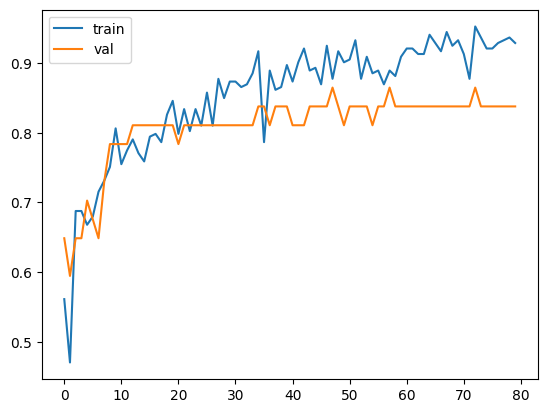

In [11]:
score_train = score[score['phase']=='train']
score_test = score[score['phase']=='val']
plt.plot(score_train['epoch'], score_train['acc'], label='train')
plt.plot(score_test['epoch'], score_test['acc'], label='val')
plt.legend()
plt.show()

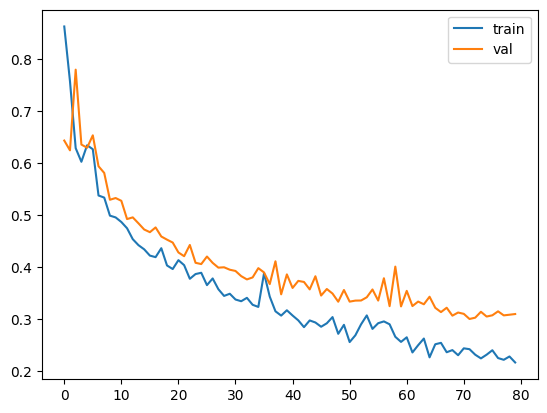

In [12]:
score_train = score[score['phase']=='train']
score_test = score[score['phase']=='val']
plt.plot(score_train['epoch'], score_train['loss'], label='train')
plt.plot(score_test['epoch'], score_test['loss'], label='val')
plt.legend()
plt.show()

In [13]:
net.to('cpu').load_state_dict(torch.load(os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOCHS}_best_loss_bin2.pth')))
net.to(device)
test_dataset = CustomDataset(test_df, phase='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
pred_test = predict(net, test_dataloader)
df_pred = pd.DataFrame(pred_test, columns=['predicted_label'])
df_pred.to_csv(os.path.join(DIR,f'pred_test_vith14_best_loss_bin2_ep{EPOCHS}.csv'), index=False)

<ipython-input-13-681cff6496d4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.to('cpu').load_state_dict(torch.load(os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOC

In [14]:
from datetime import datetime

test_df['key'] = test_df['file_name'].apply(lambda x: os.path.basename(x))
test_df['predicted_label'] = df_pred['predicted_label'].values

now = datetime.now()

# ファイル名と予測結果をDataFrameに変換
#判別結果をDataFrameに変換し、tsvファイルに出力
submit_file = f'/content/drive/MyDrive/DXQuest_PBL02/ID100822_PBL02_ver{now:%Y%m%d%H%M%S}.tsv'
print(submit_file)
test_df[['key','predicted_label']].to_csv(submit_file,
         index=False,
         header=False,
         sep='\t')

/content/drive/MyDrive/DXQuest_PBL02/ID100822_PBL02_ver20241001143343.tsv


In [15]:
net.to('cpu').load_state_dict(torch.load(os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOCHS}_best_acc_bin2.pth')))
net.to(device)
test_dataset = CustomDataset(test_df, phase='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
pred_test = predict(net, test_dataloader)
df_pred = pd.DataFrame(pred_test, columns=['predicted_label'])
df_pred.to_csv(os.path.join(DIR,f'pred_test_vith14_best_acc_bin2_ep{EPOCHS}.csv'), index=False)

<ipython-input-15-c9e389bdd07b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.to('cpu').load_state_dict(torch.load(os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOC

In [16]:
from datetime import datetime

test_df['key'] = test_df['file_name'].apply(lambda x: os.path.basename(x))
test_df['predicted_label'] = df_pred['predicted_label'].values

now = datetime.now()

# ファイル名と予測結果をDataFrameに変換
#判別結果をDataFrameに変換し、tsvファイルに出力
submit_file = f'/content/drive/MyDrive/DXQuest_PBL02/ID100822_PBL02_ver{now:%Y%m%d%H%M%S}.tsv'
print(submit_file)
test_df[['key','predicted_label']].to_csv(submit_file,
         index=False,
         header=False,
         sep='\t')

/content/drive/MyDrive/DXQuest_PBL02/ID100822_PBL02_ver20241001143659.tsv


In [17]:
net.to('cpu').load_state_dict(torch.load(os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOCHS}_{iter}_bin2.pth')))
net.to(device)
test_dataset = CustomDataset(test_df, phase='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
pred_test = predict(net, test_dataloader)
df_pred = pd.DataFrame(pred_test, columns=['predicted_label'])
df_pred.to_csv(os.path.join(DIR,f'pred_test_vith14_final_bin2_ep{EPOCHS}.csv'), index=False)

<ipython-input-17-2ff3e9550ea9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.to('cpu').load_state_dict(torch.load(os.path.join(MODEL_DIR, f'vith14_seed{seed}_ep{EPOC

In [18]:
from datetime import datetime

test_df['key'] = test_df['file_name'].apply(lambda x: os.path.basename(x))
test_df['predicted_label'] = df_pred['predicted_label'].values

now = datetime.now()

# ファイル名と予測結果をDataFrameに変換
#判別結果をDataFrameに変換し、tsvファイルに出力
submit_file = f'/content/drive/MyDrive/DXQuest_PBL02/ID100822_PBL02_ver{now:%Y%m%d%H%M%S}.tsv'
print(submit_file)
test_df[['key','predicted_label']].to_csv(submit_file,
         index=False,
         header=False,
         sep='\t')

/content/drive/MyDrive/DXQuest_PBL02/ID100822_PBL02_ver20241001144011.tsv
